## Assignment 1 
Name: Navaneethakrishnan

Roll no.: DA24S008


### Question 1 (2 Marks)
Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use ```from keras.datasets import fashion_mnist``` for getting the fashion mnist dataset.

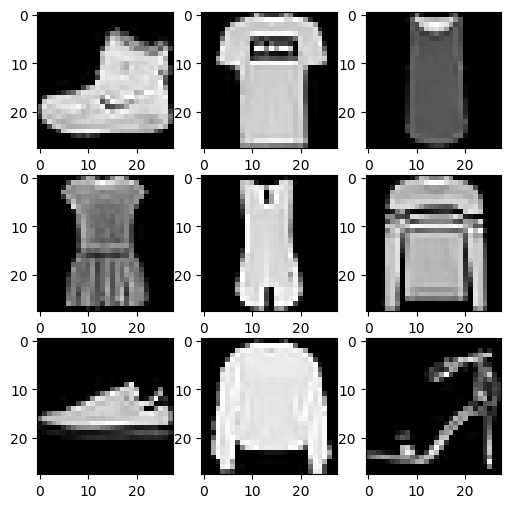

In [ ]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

no_class = 9

plt.figure(figsize=(6,6))  
for i in range(no_class):
    plt.subplot(3, 3, i+1)
    plt.imshow(xTrain[i], cmap="gray")  
plt.show()


### Question 2 (10 Marks)

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

Reference for solution
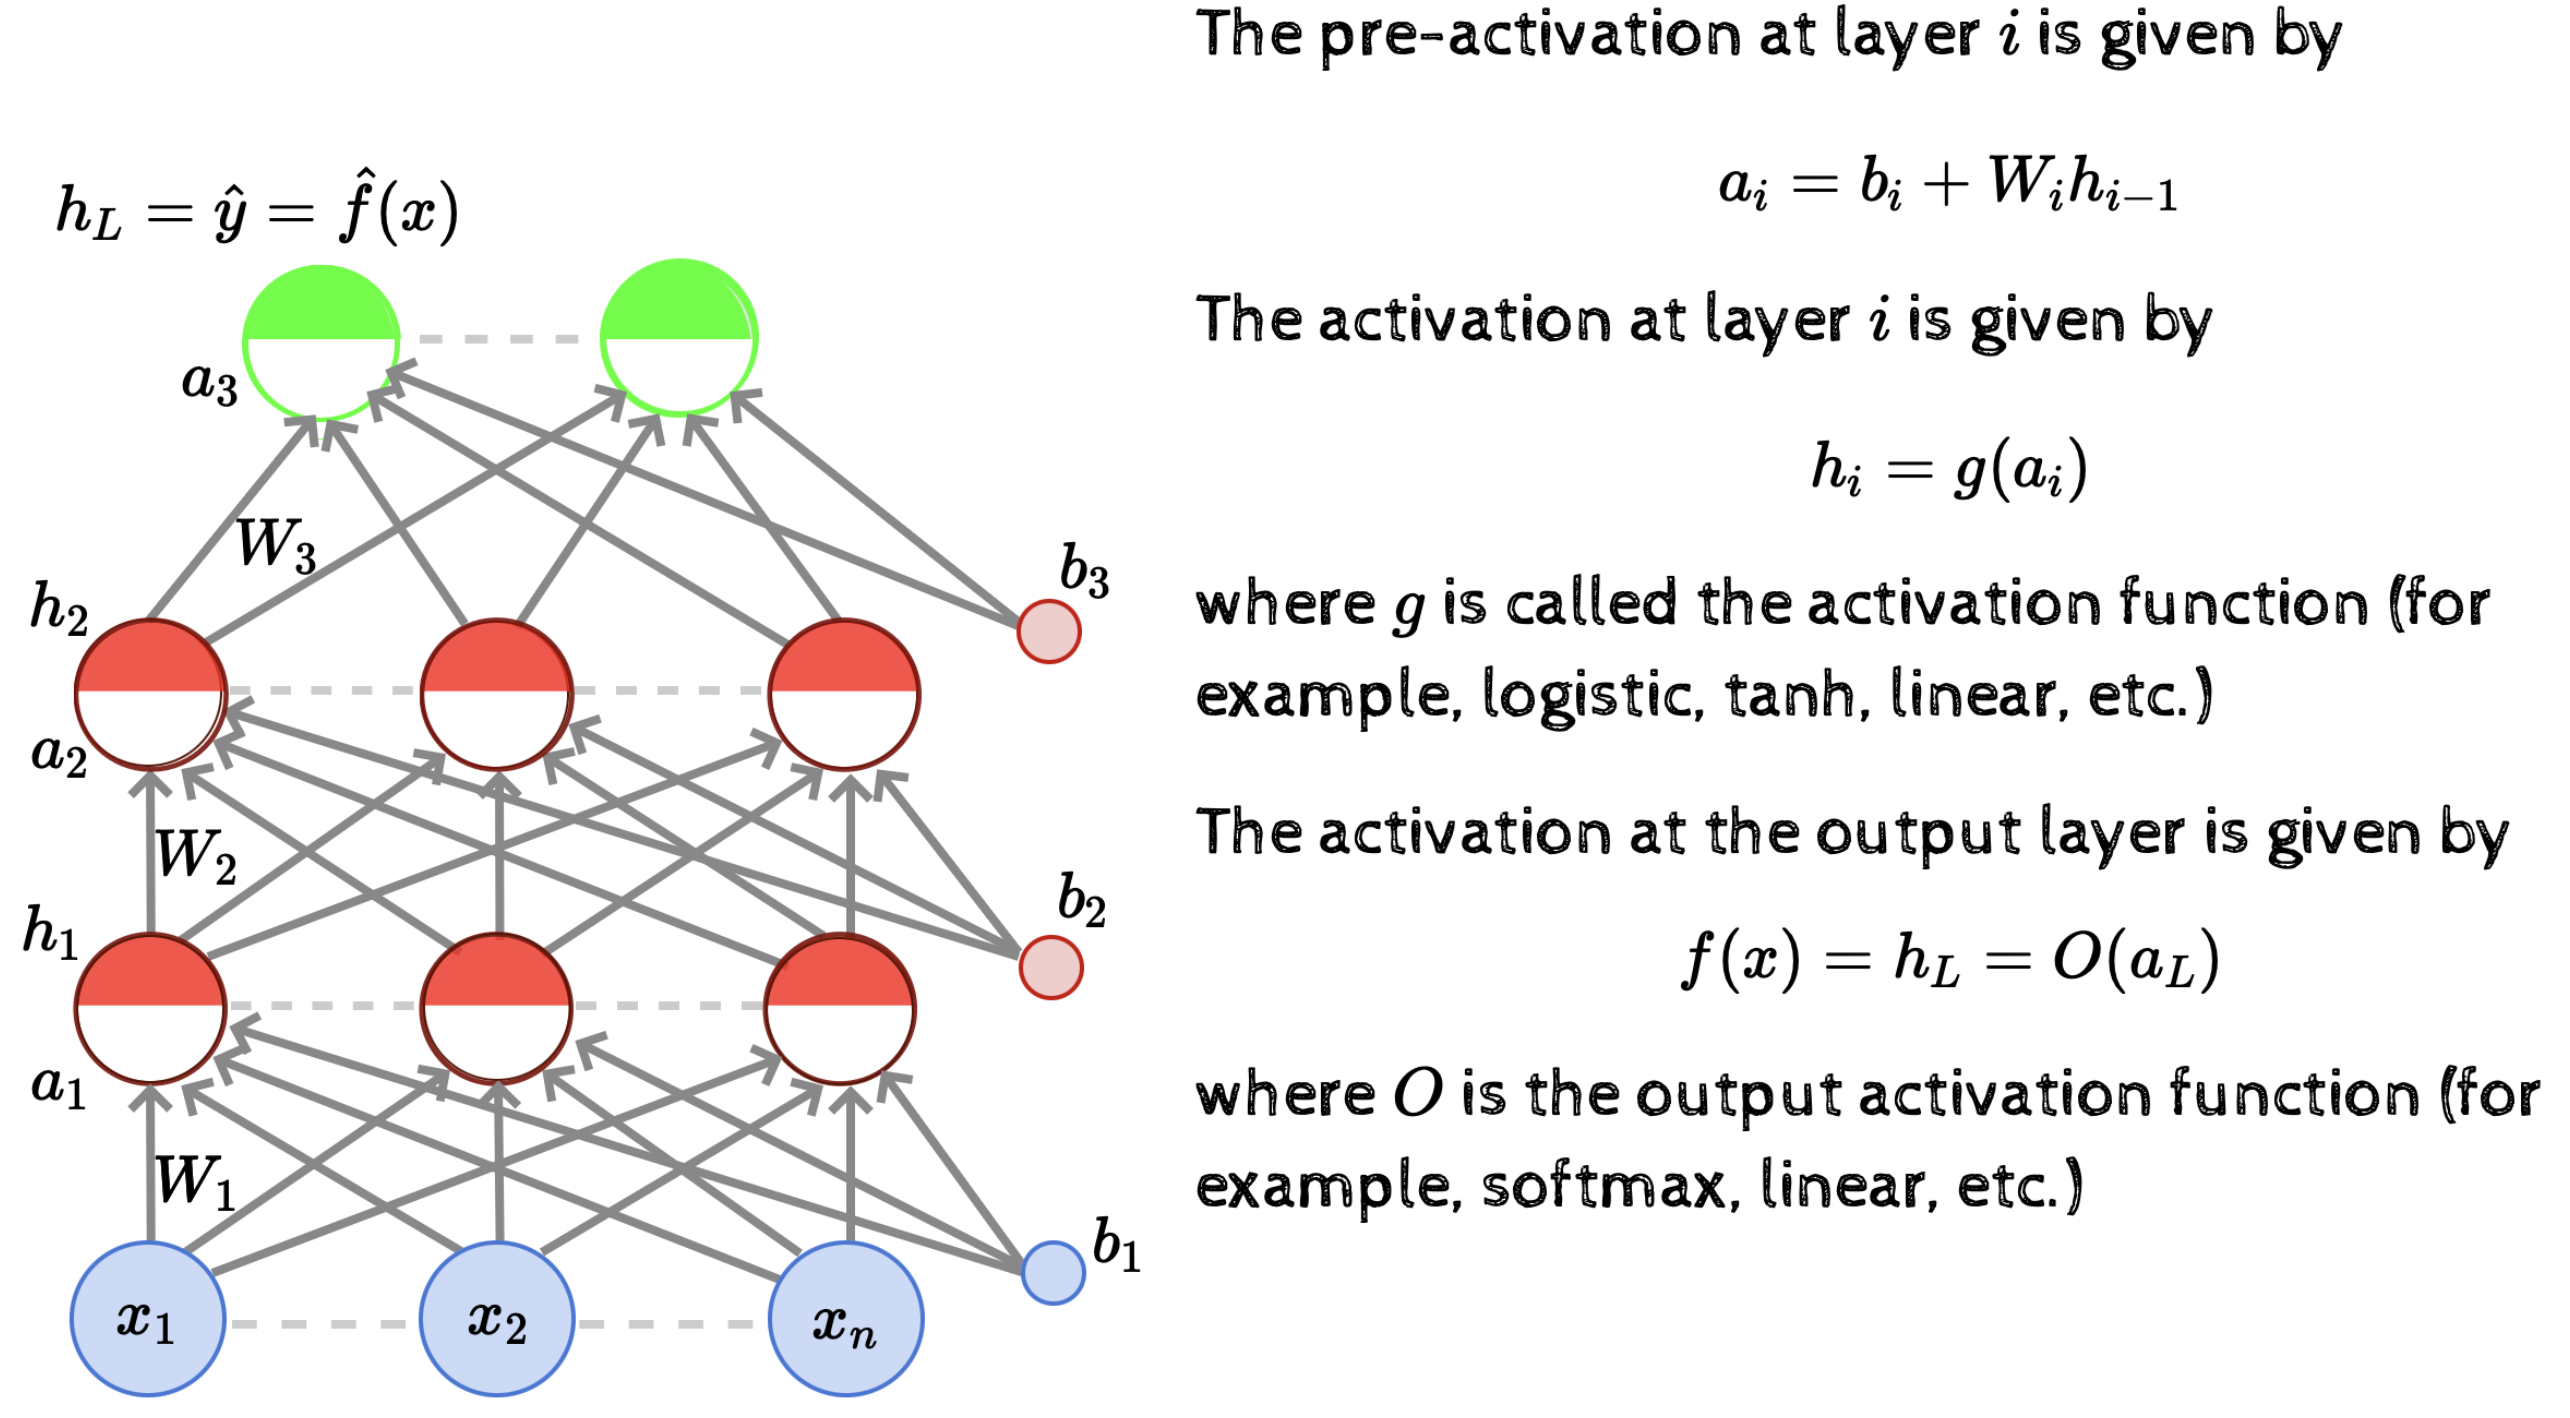

The activation function "g" used in the solution is sigmoid function


In [ ]:
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist


(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

X = xTrain.T
Y = yTrain

num_class = 10

#number of neurons per hidden layer and number of hidden layers
no_neurons = 50
no_hiddenLayers = 7


def sigmoid(x):
    return 1/(1+np.exp(-x))

def neuron(input, w, b, activation):
    z = np.dot(input, w)+b
    return activation(z)

def hiddenLayer(input, w, b, activation):
    output = np.dot(input, w)+b
    return activation(output)



def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp/np.sum(exp, axis=1, keepdims=True)

class feed_for_nn:
    def __init__(self, input_size, hidden_layers, output_size):
        self.layers = [input_size] + hidden_layers + [output_size]  
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * 0.01 for i in range(len(self.layers) - 1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers) - 1)]
    

    def forward_pass(self, X):
        self.a = [X]

        for i in range (len(self.weights)):
            if i == len(self.weights) - 1:
                activation = softmax
            else:
                activation = sigmoid
            layer_op = hiddenLayer(self.a[-1], self.weights[i], self.biases[i], activation)
            self.a.append(layer_op)
        return self.a[-1]
    
  
xTest = xTest.reshape(xTest.shape[0], -1)/255.0

hidden_layers = []

for i in range(no_hiddenLayers):
    neurons = no_neurons
    hidden_layers.append(neurons)


model = feed_for_nn(784, hidden_layers, num_class)

output_probs = model.forward_pass(xTest)

num_test_images = int(input(f"number of images to get the probability distribution: "))

print(output_probs[:5])



[[0.10355894 0.09560904 0.10071149 0.0943806  0.09876677 0.10020147
  0.11187157 0.09946507 0.10077533 0.09465974]
 [0.10355894 0.09560904 0.10071149 0.0943806  0.09876677 0.10020147
  0.11187157 0.09946507 0.10077533 0.09465974]
 [0.10355894 0.09560904 0.10071149 0.0943806  0.09876677 0.10020147
  0.11187157 0.09946507 0.10077533 0.09465974]
 [0.10355894 0.09560904 0.10071149 0.0943806  0.09876677 0.10020147
  0.11187157 0.09946507 0.10077533 0.09465974]
 [0.10355894 0.09560904 0.10071149 0.0943806  0.09876677 0.10020147
  0.11187157 0.09946507 0.10077533 0.09465974]]


### Question 3 (24 Marks)

Implement the backpropagation algorithm with support for the following optimisation functions 

- sgd
- momentum based gradient descent
- nesterov accelerated gradient descent
- rmsprop
- adam
- nadam

(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

In [26]:
import numpy as np
from keras.datasets import fashion_mnist


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)


def onehot(y, num_class):
    one_hot = np.zeros((y.shape[0], num_class))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()
xTrain = xTrain.reshape(xTrain.shape[0], -1) / 255.0
xTest = xTest.reshape(xTest.shape[0], -1) / 255.0
yTrain = onehot(yTrain, 10)
yTest = onehot(yTest, 10)

class Optimizers:
    def __init__(self, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  
        self.v = {}  
        self.t = 0   

    def sgd(self, w, dw):
        return w - self.lr * dw

    def momentum(self, w, dw, layer_id):
        if layer_id not in self.m:
            self.m[layer_id] = np.zeros_like(w)
        self.m[layer_id] = self.beta1 * self.m[layer_id] + (1 - self.beta1) * dw
        return w - self.lr * self.m[layer_id]

    def nesterov(self, w, dw, layer_id):
        if layer_id not in self.m:
            self.m[layer_id] = np.zeros_like(w)
        v_prev = self.m[layer_id]
        self.m[layer_id] = self.beta1 * self.m[layer_id] + self.lr * dw
        return w - self.beta1 * v_prev - (1 - self.beta1) * self.m[layer_id]

    def rmsprop(self, w, dw, layer_id):
        if layer_id not in self.v:
            self.v[layer_id] = np.zeros_like(w)
        self.v[layer_id] = self.beta2 * self.v[layer_id] + (1 - self.beta2) * (dw ** 2)
        return w - self.lr * dw / (np.sqrt(self.v[layer_id]) + self.epsilon)

    def adam(self, w, dw, layer_id):
        if layer_id not in self.m:
            self.m[layer_id] = np.zeros_like(w)
        if layer_id not in self.v:
            self.v[layer_id] = np.zeros_like(w)

        self.t += 1
        self.m[layer_id] = self.beta1 * self.m[layer_id] + (1 - self.beta1) * dw
        self.v[layer_id] = self.beta2 * self.v[layer_id] + (1 - self.beta2) * (dw ** 2)

        m_hat = self.m[layer_id] / (1 - self.beta1 ** self.t)
        v_hat = self.v[layer_id] / (1 - self.beta2 ** self.t)

        return w - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

    def nadam(self, w, dw, layer_id):
        if layer_id not in self.m:
            self.m[layer_id] = np.zeros_like(w)
        if layer_id not in self.v:
            self.v[layer_id] = np.zeros_like(w)

        self.t += 1
        self.m[layer_id] = self.beta1 * self.m[layer_id] + (1 - self.beta1) * dw
        self.v[layer_id] = self.beta2 * self.v[layer_id] + (1 - self.beta2) * (dw ** 2)

        m_hat = self.m[layer_id] / (1 - self.beta1 ** self.t)
        v_hat = self.v[layer_id] / (1 - self.beta2 ** self.t)

        nadam_update = self.beta1 * m_hat + (1 - self.beta1) * dw / (1 - self.beta1 ** self.t)
        return w - self.lr * nadam_update / (np.sqrt(v_hat) + self.epsilon)
    
optimizers = Optimizers(learning_rate=0.001)

class BackpropagationNN:
    def __init__(self, input_size, hidden_layers, output_size, optimizer):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i + 1]) * 0.01 for i in range(len(self.layers) - 1)]
        self.biases = [np.zeros((1, self.layers[i + 1])) for i in range(len(self.layers) - 1)]
        self.optimizer = optimizer
        self.lr = 0.001

    def forward_pass(self, X):
        self.a = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            activation = softmax if i == len(self.weights) - 1 else sigmoid
            self.a.append(activation(z))
        return self.a[-1]

    def backward_pass(self, X, Y):
        gradients = []
        dz = self.a[-1] - Y
        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.a[i].T, dz) / X.shape[0]
            db = np.sum(dz, axis=0, keepdims=True) / X.shape[0]
            gradients.append((dw, db))
            if i != 0:
                dz = np.dot(dz, self.weights[i].T) * sigmoid_derivative(self.a[i])
        gradients.reverse()
        return gradients

    def update_weights(self, gradients):
        for i, (dw, db) in enumerate(gradients):
            self.weights[i] = self.optimizer(self.weights[i], dw, i)
            self.biases[i] -= self.lr * db

    def train(self, X, Y, epochs=10, batch_size=64):
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                x_batch = X[i:i + batch_size]
                y_batch = Y[i:i + batch_size]
                self.forward_pass(x_batch)
                gradients = self.backward_pass(x_batch, y_batch)
                self.update_weights(gradients)
            print(f"Epoch {epoch + 1}/{epochs} completed")


model = BackpropagationNN(
    input_size=784,
    hidden_layers=[128, 64],
    output_size=10,
    optimizer=optimizers.adam  
)

model.train(xTrain, yTrain, epochs=10, batch_size=64)
y_pred = model.forward_pass(xTest)
predictions = np.argmax(y_pred, axis=1)
y_true = np.argmax(yTest, axis=1)




Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


### Question 4 (10 Marks)

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use ```(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()```).  Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

- number of epochs: 5, 10
- number of hidden layers:  3, 4, 5
- size of every hidden layer:  32, 64, 128
- weight decay (L2 regularisation): 0, 0.0005,  0.5
- learning rate: 1e-3, 1 e-4 
- optimizer:  sgd, momentum, nesterov, rmsprop, adam, nadam
- batch size: 16, 32, 64
- weight initialisation: random, Xavier
- activation functions: sigmoid, tanh, ReLU

wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [2]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def to_categorical(y, n_classes):
    one_hot = np.zeros((y.shape[0], n_classes))
    one_hot[np.arange(y.shape[0]), y.astype(int)] = 1
    return one_hot

def cross_ent_loss(yTrue, yPred):
        return -np.sum(yTrue * np.log(yPred + 1e-8)) / yTrue.shape[0]


def sigmoid(x): return 1 / (1 + np.exp(-x))
def sigmoid_derivative(x): return x * (1 - x)

def relu(x): return np.maximum(0, x)
def relu_derivative(x): return np.where(x > 0, 1, 0)

def tanh(x): return np.tanh(x)
def tanh_derivative(x): return 1 - np.tanh(x)**2

def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)


class Optimizers:
    def __init__(self, learning_rate):
        self.lr = learning_rate
        self.m, self.v = {}, {}
        self.t = 0

    def sgd(self, w, dw, _):
        return w - self.lr * dw

    def momentum(self, w, dw, layer_id):
        if layer_id not in self.m:
            self.m[layer_id] = np.zeros_like(w)
        self.m[layer_id] = 0.9 * self.m[layer_id] + 0.1 * dw
        return w - self.lr * self.m[layer_id]

    def adam(self, w, dw, layer_id):
        self.t += 1
        if layer_id not in self.m:
            self.m[layer_id] = np.zeros_like(w)
            self.v[layer_id] = np.zeros_like(w)
        self.m[layer_id] = 0.9 * self.m[layer_id] + 0.1 * dw
        self.v[layer_id] = 0.999 * self.v[layer_id] + 0.001 * (dw ** 2)
        m_hat = self.m[layer_id] / (1 - 0.9 ** self.t)
        v_hat = self.v[layer_id] / (1 - 0.999 ** self.t)
        return w - self.lr * m_hat / (np.sqrt(v_hat) + 1e-8)

class BackpropagationNN:
    def __init__(self, input_size, hidden_layers, output_size, optimizer, activation, batch_size, n_epochs, lr):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i + 1]) * 0.01 for i in range(len(self.layers) - 1)]
        self.biases = [np.zeros((1, self.layers[i + 1])) for i in range(len(self.layers) - 1)]
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.n_epochs = n_epochs

    def activation_function(self, x):
        return relu(x) if self.activation == 'relu' else tanh(x)

    def activation_derivative(self, x):
        return relu_derivative(x) if self.activation == 'relu' else tanh_derivative(x)

    def forward_pass(self, X):
        self.a = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            activation = softmax if i == len(self.weights) - 1 else self.activation_function
            self.a.append(activation(z))
        return self.a[-1]

    def backward_pass(self, X, Y):
        gradients = []
        dz = self.a[-1] - Y
        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.a[i].T, dz) / X.shape[0]
            db = np.sum(dz, axis=0, keepdims=True) / X.shape[0]
            gradients.append((dw, db))
            if i != 0:
                dz = np.dot(dz, self.weights[i].T) * self.activation_derivative(self.a[i])
        gradients.reverse()
        return gradients

    def update_weights(self, gradients):
        for i, (dw, db) in enumerate(gradients):
            self.weights[i] = self.optimizer(self.weights[i], dw, i)
            self.biases[i] -= wandb.config.lr * db

    

    def train(self, X_train, Y_train, X_val, Y_val):
        for _ in range(self.n_epochs):
            epochs = _
            shuffle_idx = np.random.permutation(X_train.shape[0])
            X_train, Y_train = X_train[shuffle_idx], Y_train[shuffle_idx]
            y_pred_train = self.forward_pass(X_train)
            gradients = self.backward_pass(X_train, Y_train)
            self.update_weights(gradients)

            train_loss = cross_ent_loss(Y_train, y_pred_train)
            val_loss = cross_ent_loss(self.forward_pass(X_val), Y_val)


            train_acc = accuracy_score(np.argmax(Y_train, axis=1), np.argmax(y_pred_train, axis=1))
            val_acc = accuracy_score(np.argmax(Y_val, axis=1), np.argmax(self.forward_pass(X_val), axis=1))

            wandb.log({'train_accuracy': train_acc, 'val_accuracy': val_acc, 'train_loss': train_loss, 'val_lass': val_loss, 'epoch': epochs})

(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()
xTrain, xTest = xTrain.reshape(xTrain.shape[0], -1) / 255.0, xTest.reshape(xTest.shape[0], -1) / 255.0
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.1, random_state=42, stratify=yTrain)
yTrain, yVal, yTest = to_categorical(yTrain, 10), to_categorical(yVal, 10), to_categorical(yTest, 10)

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'n_hidden': {'values': [3, 4, 5]},
        'n_hidden_units': {'values': [32, 64, 128]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10]},
        'lr': {'values': [1e-3, 1e-4]},
        'activation': {'values': ['relu', 'tanh']},
        'optim_algo': {'values': ['sgd', 'momentum', 'adam']}
    }
}

sweep_id = wandb.sweep(sweep_config, project='fashion-mnist-optim')

def train_model():
    wandb.init()
    config = wandb.config

    hidden_layers = [config.n_hidden_units] * config.n_hidden
    optimizers = Optimizers(config.lr)
    optimizer_map = {'sgd': optimizers.sgd, 'momentum': optimizers.momentum, 'adam': optimizers.adam}

    model = BackpropagationNN(784, hidden_layers, 10, optimizer_map[config.optim_algo], config.activation, config.batch_size, config.epochs, config.lr)
    model.train(xTrain, yTrain, xVal, yVal)

wandb.agent(sweep_id, train_model, count=10)


Create sweep with ID: wwuw2nm9
Sweep URL: https://wandb.ai/da24s008-indian-institute-of-technology-madras/fashion-mnist-optim/sweeps/wwuw2nm9


wandb: Agent Starting Run: lf8ldxos with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: momentum


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▅██▅▁▁▅█
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_lass,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.05994
train_loss,2.30258
val_accuracy,0.06117
val_lass,16.57861


wandb: Agent Starting Run: yqkmna6t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: momentum


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,███▆▃▁▁▃▃▃
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_lass,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.11489
train_loss,2.30258
val_accuracy,0.11967
val_lass,16.57861


wandb: Agent Starting Run: jjvg319c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▇▇████▇
train_loss,██▇▇▆▆▅▄▃▁
val_accuracy,▁▄▆▇████▇▆
val_lass,██▇▇▇▆▅▄▃▁
epoch,9
train_accuracy,0.43683
train_loss,2.30236
val_accuracy,0.41267
val_lass,16.57806


wandb: Agent Starting Run: 68ssgso5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆███▇▆▅▅
train_loss,██▇▇▇▆▆▅▃▁
val_accuracy,▁▅██▇▆▅▃▃▂
val_lass,███▇▇▆▆▅▃▁
epoch,9
train_accuracy,0.14924
train_loss,2.30255
val_accuracy,0.1455
val_lass,16.57853


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v1qxxn2v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: sgd


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,███████▁▁▁
val_accuracy,▁▃▄▅▆▇▇███
val_lass,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.14694
train_loss,2.30258
val_accuracy,0.14567
val_lass,16.57861


wandb: Agent Starting Run: uuxru0y7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: sgd


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_lass,▁▁▁▁▁
epoch,4
train_accuracy,0.09146
train_loss,2.30258
val_accuracy,0.0895
val_lass,16.57861


wandb: Agent Starting Run: bkyczoke with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: momentum


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_lass,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.15876
train_loss,2.30258
val_accuracy,0.1555
val_lass,16.57861


wandb: Agent Starting Run: hot90tj3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: momentum


epoch,▁▃▅▆█
train_accuracy,▅█▅▅▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_lass,▁▁▁▁▁
epoch,4
train_accuracy,0.16435
train_loss,2.30258
val_accuracy,0.16317
val_lass,16.57861


wandb: Agent Starting Run: f8sxirer with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: sgd


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▃▄▆▆▇▇█
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▁▃▃▆▆▆▆██
val_lass,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.06898
train_loss,2.30259
val_accuracy,0.0665
val_lass,16.57862


wandb: Agent Starting Run: 5usnma5h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: adam


epoch,▁▃▅▆█
train_accuracy,▁██▇▆
train_loss,█▇▇▅▁
val_accuracy,██▅▁▇
val_lass,██▇▅▁
epoch,4
train_accuracy,0.18039
train_loss,2.30255
val_accuracy,0.20267
val_lass,16.57847
